In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns',None)


#### Download the data from my github

In [2]:
## Remember to click "view raw" of the csv file before you copying the link to below.

train_path = 'https://raw.githubusercontent.com/Mahsarnzh/Don-t-Get-Kicked/Ziang/me2300_data/train.csv'
train_df = pd.read_csv(train_path, index_col=False, error_bad_lines=False)

test_path = 'https://raw.githubusercontent.com/Mahsarnzh/Don-t-Get-Kicked/Ziang/me2300_data/test.csv'
test_df = pd.read_csv(test_path, index_col=False, error_bad_lines=False)

submissions_df_path = 'https://raw.githubusercontent.com/Mahsarnzh/Don-t-Get-Kicked/Ziang/me2300_data/sample_submission.csv'
submissions_df = pd.read_csv(submissions_df_path, index_col=False, error_bad_lines=False)

train_df.tail(3)



,IsBadBuy,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,IsOnlineSale,WarrantyCost
25307,1,2,JEEP,PATRIOT FWD 4C,Spo,4D SUV SPORT,BLACK,AUTO,1.0,Alloy,62033,AMERICAN,SMALL SUV,8132.0,9389.0,12889.0,14036.0,8344.0,9618.0,12807.0,13642.0,8600.0,0,825
25308,0,6,CHEVROLET,MONTE CARLO 3.4L V6,LS,2D COUPE LS,BLACK,AUTO,1.0,Alloy,83081,AMERICAN,LARGE,3935.0,5111.0,4750.0,6020.0,3596.0,4893.0,4384.0,5784.0,3940.0,0,2452
25309,1,3,FORD,FUSION 4C,SE,4D SEDAN SE,GREY,AUTO,1.0,Alloy,72427,AMERICAN,MEDIUM,10257.0,11660.0,13867.0,14963.0,10290.0,11680.0,13921.0,15213.0,7415.0,0,803


## Most Common Functions

In [3]:
def drop_ManyPrices():
  train_df.drop(['MMRAcquisitionAuctionAveragePrice','MMRAcquisitionRetailAveragePrice','MMRCurrentAuctionAveragePrice','MMRCurrentRetailAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice'],axis=1,inplace=True)
  test_df.drop(['MMRAcquisitionAuctionAveragePrice','MMRAcquisitionRetailAveragePrice','MMRCurrentAuctionAveragePrice','MMRCurrentRetailAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice' ],axis=1,inplace=True)

In [4]:
def drop_oneCol(colName):
  train_df.drop([colName],axis=1,inplace=True)
  test_df.drop([colName],axis=1,inplace=True)

In [5]:
def replace_labels(df, col_df, original_Key, new_Key):
  idxs = df[(col_df == original_Key)].index
  col_df[idxs] = new_Key

In [6]:
def refine_labels_of_eachCol_5Layer(df, test_df ,targetcolName, colName, CriticalRatioList):
  x_titles = df[colName].value_counts().keys()
  y_titles = [None] * len(x_titles)
  for idx in range(len(x_titles)):
    curr = df[(df[colName] == x_titles[idx])].count()[1]
    curr_bad = df[(df[colName] == x_titles[idx])&(df[targetcolName] ==1)].count()[1]
    ratio = curr_bad/curr
    y_titles[idx] = ratio
    original_Key = x_titles[idx]
    # print(str(x_titles[idx]) + "\t{0:.2%}\t".format(ratio) + str(curr))

    if (ratio <= CriticalRatioList[0]):
      newKey = 'low'
    elif ((ratio <= CriticalRatioList[1])&(ratio > CriticalRatioList[0])):
      newKey = 'mid1'
    elif ((ratio <= CriticalRatioList[2])&(ratio > CriticalRatioList[1])):
      newKey = 'mid2'
    elif ((ratio <= CriticalRatioList[3]) & (ratio > CriticalRatioList[2])):
      newKey = 'mid3'
    elif ((ratio <= CriticalRatioList[4])&(ratio > CriticalRatioList[3])):
      newKey = 'high1'
    else:
      newKey = 'high2'

    replace_labels(df, df[colName], original_Key, newKey)
    replace_labels(test_df, test_df[colName], original_Key, newKey)

In [7]:
def handle_CategoricalClowith5newLabels(col_Name, CriticalRatioList = [0.18, 0.22, 0.28, 0.32, 0.46]):
  imputed_Value = col_Name + '_unk'
  train_df[col_Name].fillna(imputed_Value,inplace=True)
  test_df[col_Name].fillna(imputed_Value,inplace=True)

  refine_labels_of_eachCol_5Layer(df = train_df, test_df = test_df ,targetcolName = 'IsBadBuy',
                         colName = col_Name, CriticalRatioList = CriticalRatioList)

  plot_distribution_ofCurrLoc(train_df, train_df[col_Name], train_df.IsBadBuy, col_Name)

In [8]:
def plot_distribution_ofCurrLoc(df, col_df, target_df, colName):
  x_titles = col_df.value_counts().keys()
  y_titles = [None] * len(x_titles)
  for idx in range(len(x_titles)):
    curr = df[(col_df == x_titles[idx])].count()[1]
    curr_bad = df[(col_df == x_titles[idx])&(target_df ==1)].count()[1]
    ratio = curr_bad/curr
    y_titles[idx] = ratio
    print(str(x_titles[idx]) + "\t{0:.2%}\t".format(ratio) + str(curr))
  
  plt.figure(figsize=(20, 8))
  plt.title("Probability of bad buys depending on "+colName,fontsize=32)
  plt.ylabel('Probability',fontsize=16)
  plt.xlabel('Maker',fontsize=16)
  sns.barplot(x=x_titles,y=y_titles)
  plt.show()

## Specialized Functions

### Handle Transmission --- combine Manual with MANUAL

In [9]:
def handle_differentExpressionOfSameLabels(col_Name, original_Key, new_Key):
  # train_df.Transmission.value_counts(dropna=False)
  train_df["Transmission"].replace("Manual","MANUAL",inplace=True)
  # train_df.Transmission.value_counts(dropna=False)

  # test_df.Transmission.value_counts(dropna=False)
  test_df["Transmission"].replace("Manual","MANUAL",inplace=True)
  # test_df.Transmission.value_counts(dropna=False)

### Function for Make handling

In [10]:
def handle_Make():
  threshold = 100 # Anything that occurs less than this will be removed.
  value_counts = train_df.Make.value_counts() # Specific column 
  to_remove = value_counts[value_counts <= threshold].index
  train_df.Make.replace(to_remove, np.nan, inplace=True)
  train_df.Make.fillna('Make_unk',inplace=True)

  print(train_df.Make.value_counts().keys())
  # px.histogram(train_df, x = "Make", color = "IsBadBuy",height=500,width=800)

  x_titles = train_df.Make.value_counts().keys()
  y_titles = [None] * len(x_titles)
  for idx in range(len(x_titles)):
    curr = train_df[(train_df.Make == x_titles[idx])].count()[1]
    curr_bad = train_df[(train_df.Make== x_titles[idx])&(train_df.IsBadBuy==1)].count()[1]
    ratio = curr_bad/curr
    y_titles[idx] = ratio
    original_Key = x_titles[idx]
    
    if (ratio <= 0.24):
      new_Key = 'low'
    elif (ratio >= 0.30):
      new_Key = 'high'
    elif ((ratio > 0.24) & (ratio < 0.30)):
      new_Key = 'mid'
    
    replace_labels(train_df, train_df.Make, original_Key, new_Key)
    replace_labels(test_df, test_df.Make, original_Key, new_Key)

  plot_distribution_ofCurrLoc(train_df, train_df['Make'], train_df.IsBadBuy, 'Make')

### function for WheelTypeID handling [handle_WheelTypeID]

In [11]:
def handle_WheelTypeID():
  train_df.drop(['WheelType'],axis=1,inplace=True)
  test_df.drop(['WheelType'],axis=1,inplace=True)

  train_df.WheelTypeID.fillna(0.0,inplace=True)
  test_df.WheelTypeID.fillna(0.0,inplace=True)

  # Alloy	22.49%	12284
  replace_labels(train_df, train_df.WheelTypeID, 1.0, 22)
  replace_labels(test_df, test_df.WheelTypeID, 1.0, 22)
  # Covers	17.35%	10922
  replace_labels(train_df, train_df.WheelTypeID, 2.0, 17)
  replace_labels(test_df, test_df.WheelTypeID, 2.0, 17)
  # WheelType_unk	84.59%	1836 np.nan
  replace_labels(train_df, train_df.WheelTypeID, 0.0, 84)
  replace_labels(test_df, test_df.WheelTypeID, 0.0, 84)
  # Special	26.87%	268
  replace_labels(train_df, train_df.WheelTypeID, 3.0, 26)
  replace_labels(test_df, test_df.WheelTypeID, 3.0, 26)

  plot_distribution_ofCurrLoc(train_df, train_df.WheelTypeID, train_df.IsBadBuy, 'WheelTypeID')

### function for Nationality handling [handle_Nationality]

In [12]:
def handle_Nationality():
  train_df['Nationality'].fillna('OTHER',inplace=True)
  test_df['Nationality'].fillna('OTHER',inplace=True)

  # OTHER ASIAN
  replace_labels(train_df, train_df.Nationality, "OTHER ASIAN", "OTHER")
  replace_labels(test_df, test_df.Nationality, "OTHER ASIAN", "OTHER")

## Start Calling functions for each Col

### Call function for Make

Index(['CHEVROLET', 'DODGE', 'FORD', 'CHRYSLER', 'PONTIAC', 'KIA', 'NISSAN',
       'SATURN', 'HYUNDAI', 'JEEP', 'SUZUKI', 'TOYOTA', 'MITSUBISHI',
       'Make_unk', 'MAZDA', 'MERCURY', 'BUICK', 'GMC', 'HONDA'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying t

low	21.39%	12415
mid	27.74%	11625
high	31.65%	1270


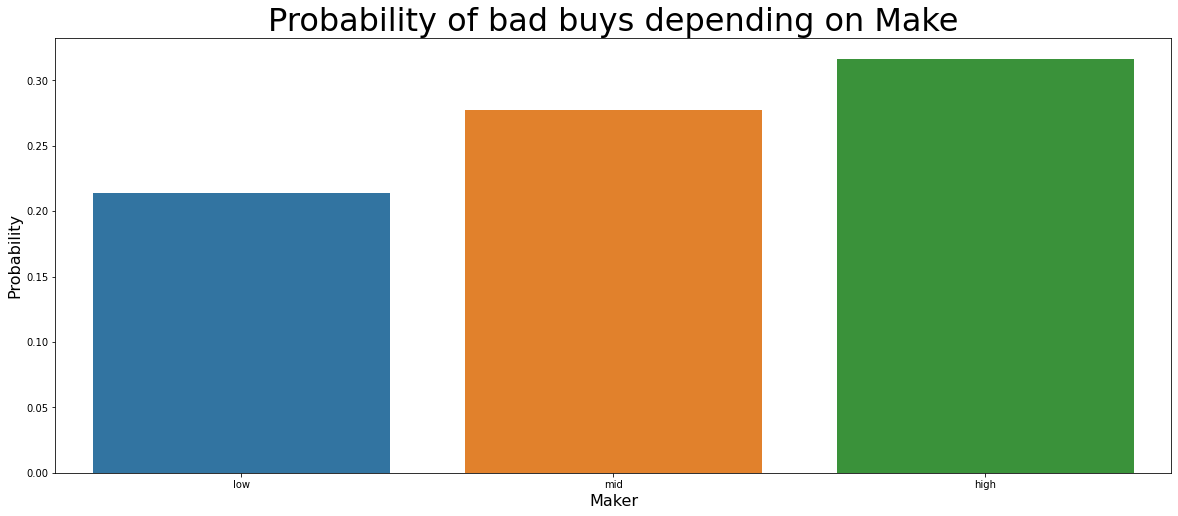

In [13]:
handle_Make()

In [14]:
# drop_oneCol('Make')

### Call function for Nationality

In [15]:
handle_Nationality()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# drop_oneCol('Nationality')

### Call function for WheelTypeID and WheelType

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying t

22.0	22.49%	12284
17.0	17.35%	10922
84.0	84.59%	1836
26.0	26.87%	268


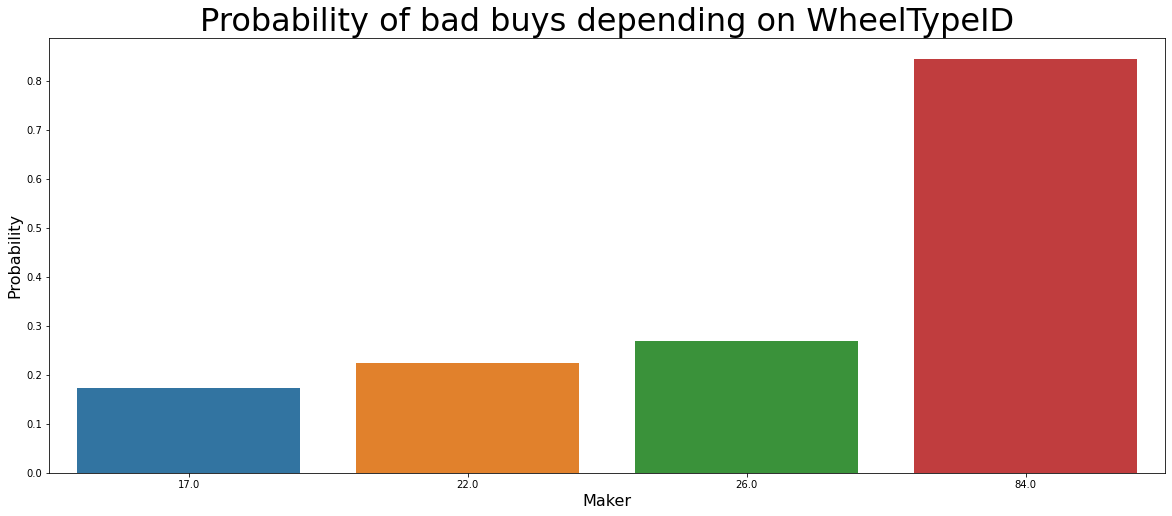

In [17]:
handle_WheelTypeID()

In [18]:
# drop_oneCol('WheelTypeID')

### Call function for Transmission

In [19]:
handle_differentExpressionOfSameLabels("Transmission", "Manual", "MANUAL")

In [20]:
# drop_oneCol('Transmission')

### Call function for Color

In [21]:
# train_df['Color'].fillna('NOT AVAIL',inplace=True)
# test_df['Color'].fillna('NOT AVAIL',inplace=True)
# handle_CategoricalClowith5newLabels('Color', [0.20, 0.22, 0.26, 0.31, 0.40])

In [22]:
drop_oneCol('Color')

### Call function for Trim


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying t

mid2	25.00%	12815
mid1	19.59%	5737
mid3	30.07%	3382
low	15.31%	1652
high1	37.38%	1565
high2	62.89%	159


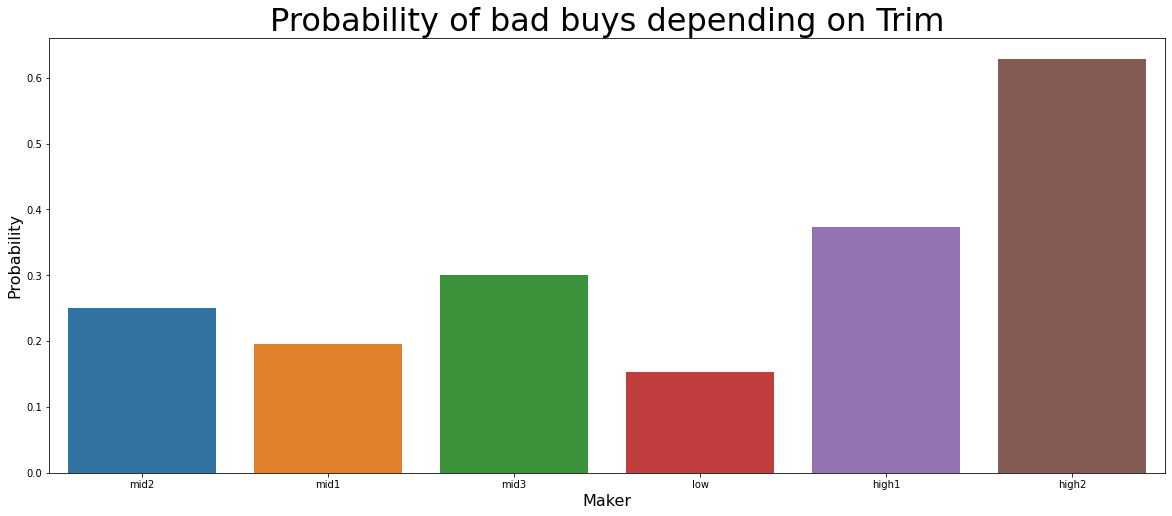

In [23]:
handle_CategoricalClowith5newLabels('Trim', [0.18, 0.22, 0.28, 0.32, 0.46])

In [24]:
# drop_oneCol('Trim')

### Call function for Model

流式输出内容被截断，只能显示最后 5000 行内容。
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

low	12.23%	7636
high1	31.60%	5105
mid3	26.31%	4109
mid1	19.94%	3897
high2	47.85%	3329
mid2	23.10%	1234


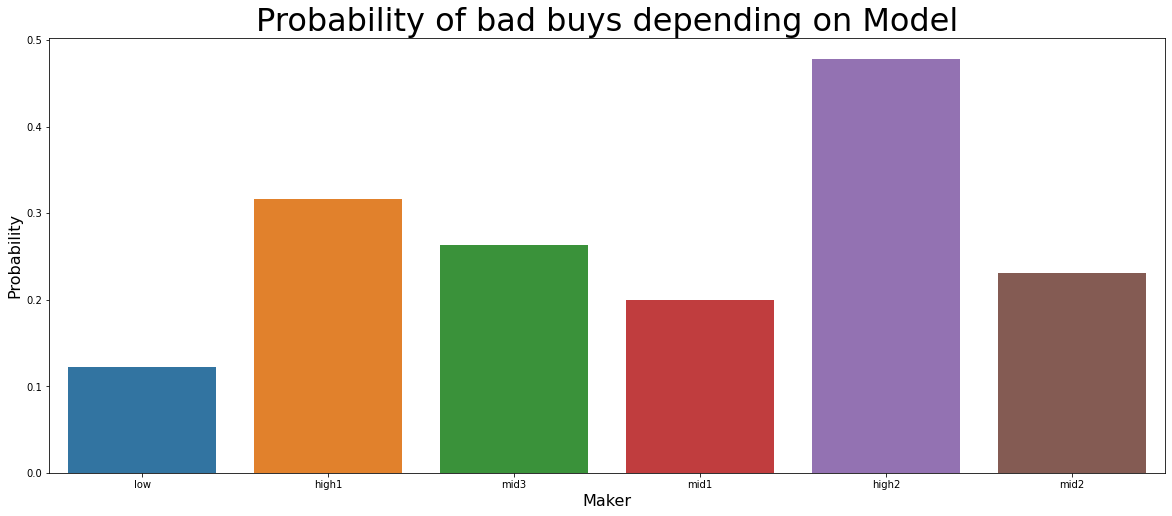

In [25]:
handle_CategoricalClowith5newLabels('Model', [0.18, 0.22, 0.24, 0.29, 0.35])

In [26]:
# drop_oneCol('SubModel')

### Call function for SubModel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying t

mid3	25.13%	8907
low	12.63%	5489
high1	31.40%	3506
mid1	20.09%	3375
high2	47.92%	2596
mid2	22.89%	1437


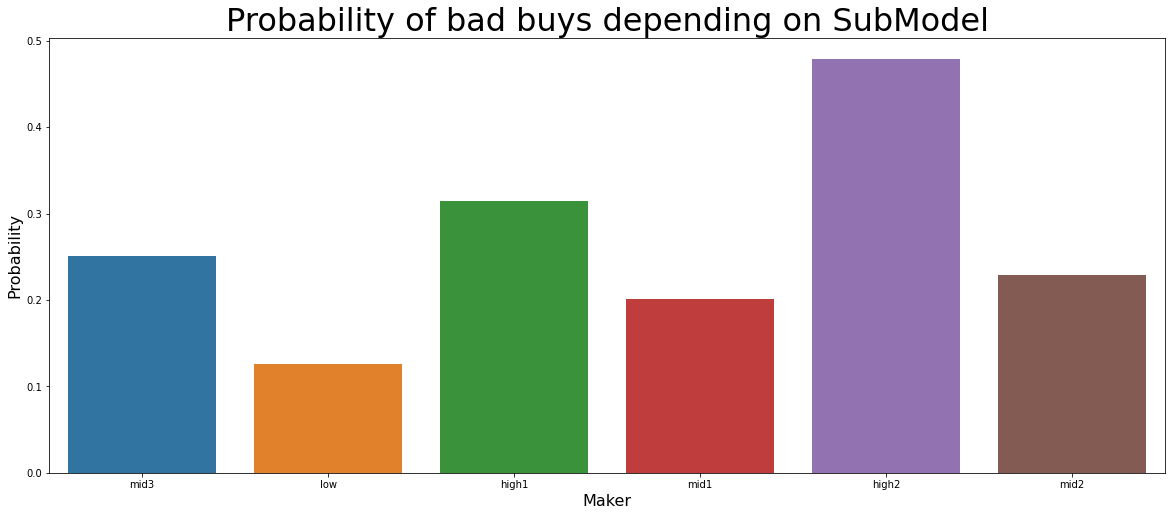

In [27]:
handle_CategoricalClowith5newLabels('SubModel', [0.18, 0.22, 0.24, 0.28, 0.35])

In [28]:
# drop_oneCol('SubModel')

### Call function for WarrantyCost

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying t

mid1	20.47%	6948
low	14.81%	5421
mid3	27.66%	4823
high1	35.72%	3357
mid2	23.50%	3285
high2	51.02%	1476


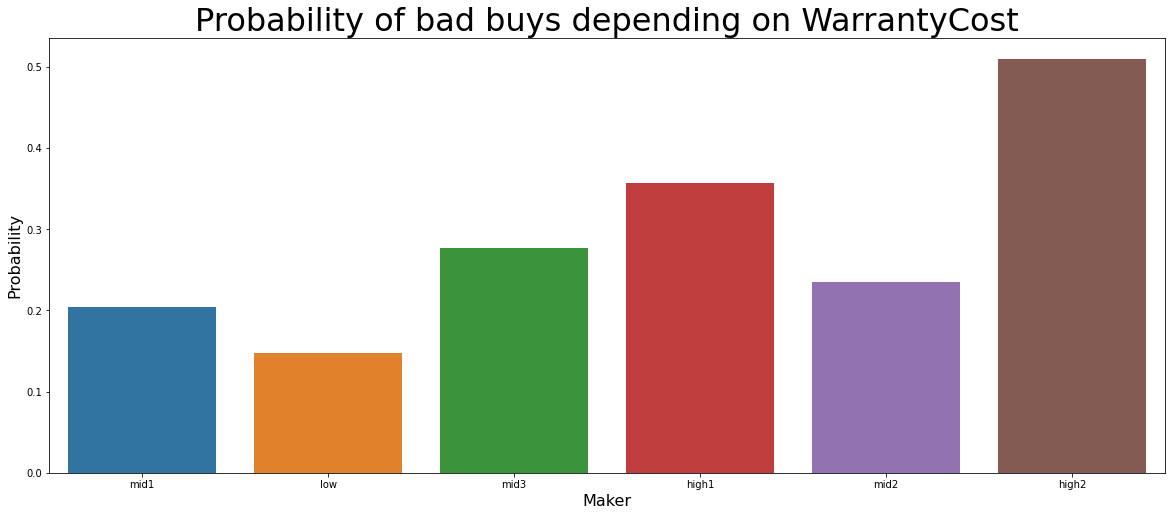

In [29]:
handle_CategoricalClowith5newLabels('WarrantyCost', [0.18, 0.22, 0.25, 0.30, 0.42])

In [30]:
# drop_oneCol('WarrantyCost')

### Call function for VehBCost


流式输出内容被截断，只能显示最后 5000 行内容。
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

low	12.05%	9171
high1	35.20%	4790
mid2	23.67%	3672
mid1	20.14%	2979
high2	55.26%	2595
mid3	28.01%	2103


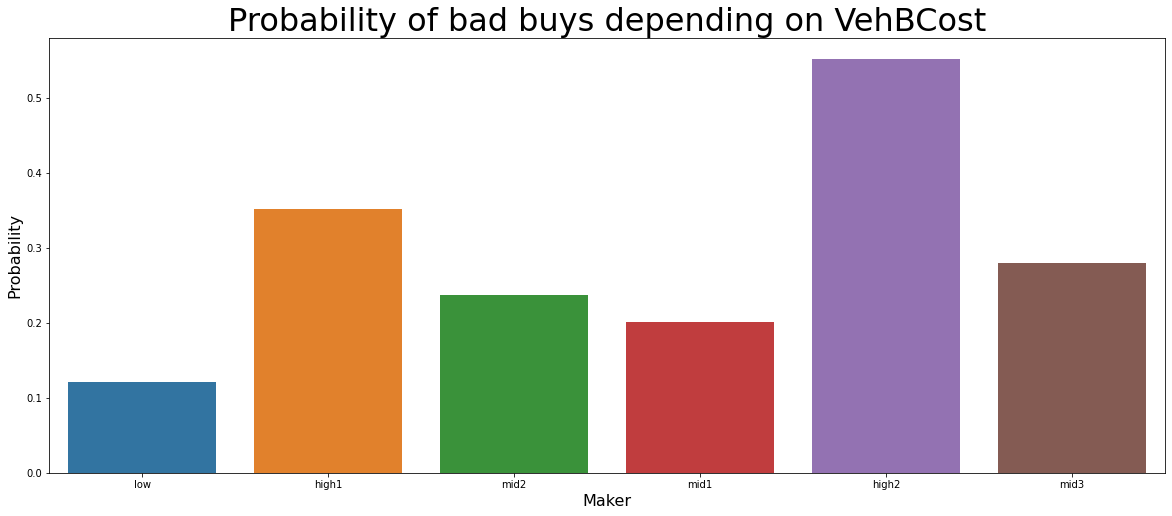

In [31]:
handle_CategoricalClowith5newLabels('VehBCost', [0.18, 0.22, 0.25, 0.30, 0.42])

In [32]:
# drop_oneCol('VehBCost')

### Call function for Size


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying t

mid2	23.35%	12278
high1	30.29%	6009
mid3	26.31%	3113
mid1	18.83%	2964
low	17.86%	655
high2	35.05%	291


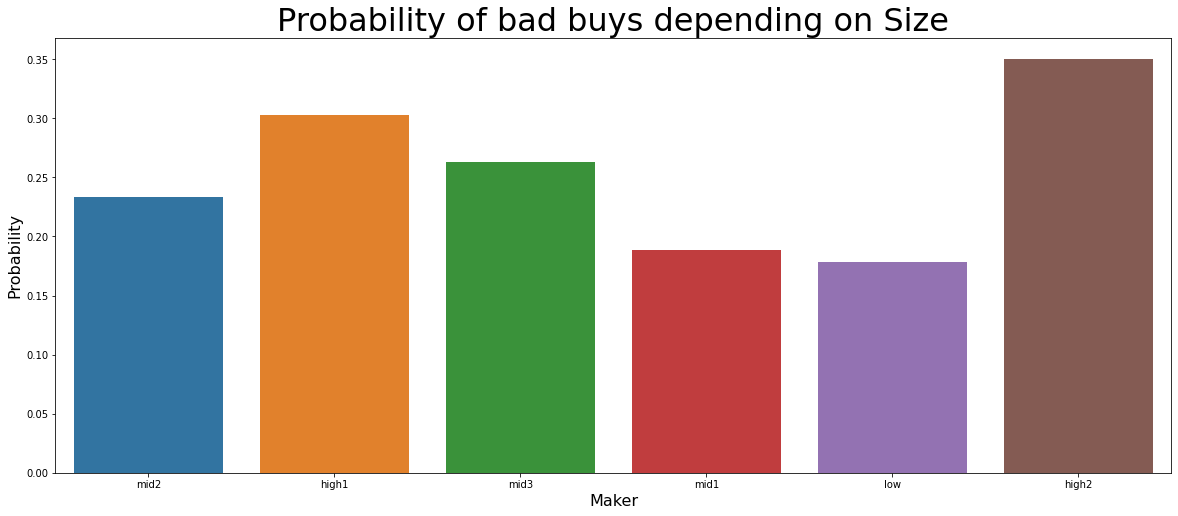

In [33]:
handle_CategoricalClowith5newLabels('Size', [0.18, 0.22, 0.25, 0.29, 0.32])

In [34]:
# drop_oneCol('Size')

### Call function for VehOdo


In [35]:
# handle_CategoricalClowith5newLabels('VehOdo', [0.18, 0.22, 0.25, 0.29, 0.32])

In [36]:
drop_oneCol('VehOdo')

## Target Spliting

In [37]:
targets=train_df['IsBadBuy']
train_df.drop('IsBadBuy',axis=1,inplace=True)

## Save before Encoding

In [38]:
train_file_beforeEncoding = 'Train_file_beforeEncoding.csv'
test_file_beforeEncoding = 'Test_file_beforeEncoding.csv'
targets_file = 'targets.csv'

In [39]:
targets.to_csv(targets_file,index=False)

In [40]:
train_df.to_csv(train_file_beforeEncoding,index=False)

In [41]:
test_df.to_csv(test_file_beforeEncoding,index=False)

## HotEncoding

In [42]:
categorical_cols = train_df.select_dtypes(include = 'object').columns.tolist()
numeric_cols = train_df.select_dtypes(exclude='object').columns.tolist()

In [43]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder.fit(train_df[categorical_cols])
encoded_cols=list(encoder.get_feature_names_out(categorical_cols))
train_df[encoded_cols]=encoder.transform(train_df[categorical_cols]);
test_df[encoded_cols]=encoder.transform(test_df[categorical_cols]);
# get_feature_names_out

In [44]:
train_df=train_df[numeric_cols+encoded_cols]
test_df=test_df[numeric_cols+encoded_cols]

# Saving after Encoding

In [45]:
train_file_afterEncoding = 'Train_file_afterEncoding.csv'
test_file_afterEncoding = 'Test_file_afterEncoding.csv'
targets_file = 'targets.csv'

In [46]:
train_df.to_csv(train_file_afterEncoding,index=False)

In [47]:
test_df.to_csv(test_file_afterEncoding,index=False)

## Download it

In [55]:
from google.colab import files

In [56]:
files.download(train_file_afterEncoding)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
files.download(test_file_afterEncoding)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
files.download(train_file_beforeEncoding)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
files.download(test_file_beforeEncoding)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
files.download(targets_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>